# Geographical survey of broadband availability by block from Form 477 

## Quetions to be answered

1. Availability by speed and RUCA code
2. What are the geographical characteristics of the blocks for which there is no record in Form 477 (i.e., no provider)?
3. Identifying "institutional" blocks with Census address data and demographical data from ACS 2019 5-year estimate 


In [1]:
import collections
import functools
import os
import sys
import time
import numpy as np
import pandas as pd
import dask as d
import dask.dataframe as dd
from dask.diagnostics import ProgressBar

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
# plt.rcParams.update({'font.size': 50})
plt.rcParams['font.size'] = 20
plt.rcParams['figure.figsize'] = [8, 6]
sns.set()

print("Timestamp")
print(time.strftime(r'%Y-%m-%d %H:%M:%S%Z', time.gmtime()))
print("Versions")
print("Python:", sys.version_info)
print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("dask:", d.__version__)


Timestamp
2021-05-14 07:52:03UTC
Versions
Python: sys.version_info(major=3, minor=8, micro=8, releaselevel='final', serial=0)
numpy: 1.20.1
pandas: 1.2.4
dask: 2021.04.0


In [59]:
# No copy warning
pd.options.mode.chained_assignment = None 

## Importing data


### Broadband Availability from FCC Form 477

In [2]:
# Aggregate partitioned files into one using Dask
file_address = "../form477_data/form477_jun2020_ruca_blockpop_00000000000*"
df = dd.read_csv(file_address, dtype = {'BlockCodeStr' : str,
                                        'TractCode' : str, 
                                        'BlockGroupCode' : str})
# Drop columns we won't need
df = df.loc[:,
    ['BlockCodeStr','TractCode','BlockGroupCode','D10_1','D25_3','D100_10',
     'ProviderCount']]
df.head()

BlockCodeStr    TractCode BlockGroupCode  D10_1  D25_3  D100_10  \
0  360810999001028  36081099900   360810999001  False  False    False   
1  360810299001000  36081029900   360810299001   True   True     True   
2  511339901000006  51133990100   511339901000   True   True    False   
3  360810999001029  36081099900   360810999001  False  False    False   
4  290959892001004  29095989200   290959892001  False  False    False   

   ProviderCount  
0              1  
1              2  
2              1  
3              1  
4              1

In [3]:
# Convert to a PD dataframe from Dask
with ProgressBar():
    form477_df = df.compute()

[########################################] | 100% Completed | 12.9s


### A complete list of census blocks from 2010 Decennial Census from FCC staff

- US total number of 2010 Census blocks: 11,078,297
- US contiguous states and D.C. blocks: 11,007,989

Source: Census Bureau's tally [link](https://www.census.gov/geographies/reference-files/time-series/geo/tallies.html)

We must use this list (tabulated by FCC staff [link](https://www.fcc.gov/general/census-blocks-state) based on blocks as of 2010 Decennial Census) to match with Form 477 data as geocodes in Form 477 still follow the block designations in 2010.

In [4]:
all_blocks = pd.read_csv('../all_census_blocks_2010/all_census_blocks_2010.csv', dtype = str)
all_blocks.shape

(11007989, 2)

### RUCA from USDA

In [5]:
# RUCA (tract level)
df_ruca = pd.read_csv('ruca.csv', dtype={'geocode':str, 'ruca':int})
df_ruca = df_ruca[['geoid', 'state', 'county', 'ruca']]
df_ruca['geoid'] = df_ruca['geoid'].str[9:]

### FCC staff 2019 population estimate
Block-level population estimates consistent with ACS data. The population data was calculated by the FCC staff. Source [link](https://www.fcc.gov/staff-block-estimates)

In [6]:
fields = ['block_fips', 'pop2019']
df_pop2019 = pd.read_csv('../us2019/us2019.csv', usecols=fields, dtype={'block_fips':str, 'pop2019':int})

### Match and combine the data

1. Left merge the list all blocks with FCC Form 477 data on a block level
2. Left merge the list all blocks with RUCA data on a tract level
2. Left merge the list all blocks with FCC population estimate data on a block level

In [7]:
combined_df = pd.merge(left = all_blocks['blockcode'], right = form477_df, 
                       left_on='blockcode', right_on='BlockCodeStr', how='left')

combined_df = pd.merge(left = combined_df, right = df_ruca, 
                       left_on='TractCode', right_on='geoid', how='left')

combined_df = pd.merge(left = combined_df, right = df_pop2019, 
                       left_on='blockcode', right_on='block_fips', how='left')

In [8]:
# Fill up missing geocodes for blocks, tracts and block groups
# BlockCodeStr
combined_df.loc[combined_df['BlockCodeStr'].isna(),'BlockCodeStr'] = combined_df.loc[combined_df['BlockCodeStr'].isna(),'blockcode']
# TractCode
combined_df.loc[combined_df['TractCode'].isna(),'TractCode'] = combined_df.loc[combined_df['TractCode'].isna(),'blockcode'].str[:11]
# BlockGroup
combined_df.loc[combined_df['BlockGroupCode'].isna(),'BlockGroupCode'] = combined_df.loc[combined_df['BlockGroupCode'].isna(),'blockcode'].str[:12]

# Look for a mismatch (should return zero rows)
combined_df.loc[combined_df['blockcode']!=combined_df['BlockCodeStr'],:]

Empty DataFrame
Columns: [blockcode, BlockCodeStr, TractCode, BlockGroupCode, D10_1, D25_3, D100_10, ProviderCount, geoid, state, county, ruca, block_fips, pop2019]
Index: []

In [9]:
# Clean-up
combined_df = combined_df.loc[:,['BlockCodeStr','TractCode','BlockGroupCode','D10_1','D25_3','D100_10',
 'ProviderCount','state','county','ruca','pop2019']]

### Sanity check

- We only consider 48 contiguous states + Washington D.C.
- Exclude outlying territories
- 49 staate-equivalent regions in total

In [10]:
# We get 50 because of NaN
len(set(combined_df['state']))

50

### Dealing with FIPS code change (46113 &#8594; 46102, 51515 &#8594; 51019)

Reference: https://www.census.gov/programs-surveys/geography/technical-documentation/county-changes.2010.html

Note that in 2015 South Dakota, Shannon County (FIPS 46113) was renamed to Oglala Lakota County (FIPS 46102) as of May 1st, 2015. Action: check if FIPS code 46113***** exist, possibly replace with the new code 46102. The FCC data seem to follow a 2010 version of geographical codes. This must be rectified before merging with the latest ACS data to avoid mismatches.

Virginia, 2013: Bedford (independent) city (FIPS 51515) was changed to town status and added to Bedford County (FIPS 51019) effective July 1st, 2013. 

*This issue must be addressed before joining the ACS set.*

In [11]:
# Oglala Lakota County SD, previously known as Shannon County
# Change FIPS code
combined_df.loc[
    (combined_df['county'] == 'Shannon County') & (combined_df['state'] == 'SD'), 
        ['BlockCodeStr','TractCode','BlockGroupCode']] = combined_df.loc[
    (combined_df['county'] == 'Shannon County') & (combined_df['state'] == 'SD'),
        ['BlockCodeStr','TractCode','BlockGroupCode']].apply(lambda x: x.str.replace('46113','46102'), axis = 1)
# Change name
combined_df.loc[(combined_df['county'] == 'Shannon County') & (combined_df['state'] == 'SD'), 'county'] = 'Oglala Lakota County'

# Bedford City VA, previous city absorbed into Bedford County
# Change FIPS code
combined_df.loc[
    (combined_df['county'] == 'Bedford city') & (combined_df['state'] == 'VA'), 
        ['BlockCodeStr','TractCode','BlockGroupCode']] = combined_df.loc[
    (combined_df['county'] == 'Bedford city') & (combined_df['state'] == 'VA'),
        ['BlockCodeStr','TractCode','BlockGroupCode']].apply(lambda x: x.str.replace('51515','51019'), axis = 1)
# Change name
combined_df.loc[(combined_df['county'] == 'Bedford city') & (combined_df['state'] == 'VA'), 'county'] = 'Bedford County'



In [12]:
combined_df.loc[combined_df['D10_1'].isna(),:].sort_values(by=['pop2019'], ascending=False).head(20)

BlockCodeStr    TractCode BlockGroupCode D10_1 D25_3 D100_10  \
1093864   060659810001001  06065981000   060659810001   NaN   NaN     NaN   
1317094   060952530001015  06095253000   060952530001   NaN   NaN     NaN   
385957    040137233061092  04013723306   040137233061   NaN   NaN     NaN   
4231308   240037067001042  24003706700   240037067001   NaN   NaN     NaN   
784351    060250123011297  06025012301   060250123011   NaN   NaN     NaN   
1177914   060730100141012  06073010014   060730100141   NaN   NaN     NaN   
1207631   060730219001011  06073021900   060730219001   NaN   NaN     NaN   
8334372   420912067021003  42091206702   420912067021   NaN   NaN     NaN   
10146180  510818801021002  51081880102   510818801021   NaN   NaN     NaN   
588302    050799606002047  05079960600   050799606002   NaN   NaN     NaN   
2120614   121130108081013  12113010808   121130108081   NaN   NaN     NaN   
4641693   260750058001000  26075005800   260750058001   NaN   NaN     NaN   
826414    060290065002695  06029006500   060290065002   NaN   NaN     NaN   
3268123   181339566003009  18133956600   181339566003   NaN   NaN     NaN   
1773094   120231103002032  12023110300   120231103002   NaN   NaN     NaN   
491976    040270118001038  04027011800   040270118001   NaN   NaN     NaN   
1168751   060730038001037  06073003800   060730038001   NaN   NaN     NaN   
2150534   121239504003150  12123950400   121239504003   NaN   NaN     NaN   
5154260   280419501004191  28041950100   280419501004   NaN   NaN     NaN   
9411268   482014211012000  48201421101   482014211012   NaN   NaN     NaN   

          ProviderCount state county  ruca  pop2019  
1093864             NaN   NaN    NaN   NaN     7637  
1317094             NaN   NaN    NaN   NaN     5121  
385957              NaN   NaN    NaN   NaN     5095  
4231308             NaN   NaN    NaN   NaN     4450  
784351              NaN   NaN    NaN   NaN     4085  
1177914             NaN   NaN    NaN   NaN     3926  
1207631             NaN   NaN    NaN   NaN     3926  
8334372             NaN   NaN    NaN   NaN     3395  
10146180            NaN   NaN    NaN   NaN     2895  
588302              NaN   NaN    NaN   NaN     2849  
2120614             NaN   NaN    NaN   NaN     2796  
4641693             NaN   NaN    NaN   NaN     2768  
826414              NaN   NaN    NaN   NaN     2644  
3268123             NaN   NaN    NaN   NaN     2577  
1773094             NaN   NaN    NaN   NaN     2488  
491976              NaN   NaN    NaN   NaN     2384  
1168751             NaN   NaN    NaN   NaN     2361  
2150534             NaN   NaN    NaN   NaN     2349  
5154260             NaN   NaN    NaN   NaN     2236  
9411268             NaN   NaN    NaN   NaN     2211

### Bring in ACS data for proxies for population living in Group Quarters

In [13]:
acs5yr_df = pd.read_csv('../form477_to_acs5yr/all_census_block_groups_grouppop.csv', dtype={'GEOID':str})


In [14]:
combined_df = pd.merge(left = combined_df, right = acs5yr_df, 
                       left_on='BlockGroupCode', right_on='GEOID', how='left')
combined_df.drop(['GEOID'], axis=1, inplace=True)

In [15]:
combined_df.loc[combined_df['BlockCodeStr'].duplicated(keep=False),:]

Empty DataFrame
Columns: [BlockCodeStr, TractCode, BlockGroupCode, D10_1, D25_3, D100_10, ProviderCount, state, county, ruca, pop2019, pop, cnipop, inspopshr, mpop, colpop]
Index: []

There are 54 blocks that could not be traced back to block designation as of 2010 Decennial Census. These are newly formed blocks after the 2010 Decennial Census.

In [15]:
# Blocks that did not match when left-joined with combined data
# These could be newly formed blocks after the 2010 Decennial Census
# match_fail = combined_df.loc[combined_df['BlockCodeStr'].isna(),:]
# print('Number of blocks in ACS 2019 with no match {}'.format(match_fail.shape[0]))
# match_fail.sort_values(by='pop', ascending=False).head(10)

Number of blocks in ACS 2019 with no match 54


BlockCodeStr TractCode BlockGroupCode D10_1 D25_3 D100_10  \
11007993          NaN       NaN            NaN   NaN   NaN     NaN   
11007992          NaN       NaN            NaN   NaN   NaN     NaN   
11007994          NaN       NaN            NaN   NaN   NaN     NaN   
11008003          NaN       NaN            NaN   NaN   NaN     NaN   
11007991          NaN       NaN            NaN   NaN   NaN     NaN   
11008028          NaN       NaN            NaN   NaN   NaN     NaN   
11007995          NaN       NaN            NaN   NaN   NaN     NaN   
11008037          NaN       NaN            NaN   NaN   NaN     NaN   
11008021          NaN       NaN            NaN   NaN   NaN     NaN   
11008039          NaN       NaN            NaN   NaN   NaN     NaN   

          ProviderCount state county  ruca  pop2019         GEOID     pop  \
11007993            NaN   NaN    NaN   NaN      NaN  040190041211  8593.0   
11007992            NaN   NaN    NaN   NaN      NaN  040190041181  5437.0   
11007994            NaN   NaN    NaN   NaN      NaN  040190041251  4819.0   
11008003            NaN   NaN    NaN   NaN      NaN  060371370002  3131.0   
11007991            NaN   NaN    NaN   NaN      NaN  040190029061  2547.0   
11008028            NaN   NaN    NaN   NaN      NaN  360530304032  2461.0   
11007995            NaN   NaN    NaN   NaN      NaN  040190041252  2367.0   
11008037            NaN   NaN    NaN   NaN      NaN  360650247004  2238.0   
11008021            NaN   NaN    NaN   NaN      NaN  360530304012  2233.0   
11008039            NaN   NaN    NaN   NaN      NaN  360650248002  2140.0   

          cnipop  inspopshr      mpop    colpop  
11007993  6510.0  24.240661  1.861981  7.319912  
11007992  5011.0   7.835203  1.121942  8.478941  
11007994  3947.0  18.095040  4.689770  7.926956  
11008003  3131.0   0.000000  0.000000  8.783136  
11007991  2538.0   0.353357  0.353357  9.972517  
11008028  2461.0   0.000000  0.000000  3.575782  
11007995  2367.0   0.000000  0.000000  0.000000  
11008037  2238.0   0.000000  0.000000  1.161752  
11008021  2233.0   0.000000  0.000000  1.836095  
11008039  2132.0   0.373832  0.373832  6.214953

In [16]:
# Blocks that did not have any values for the ACS variables 
# (possibly population fewer than 10. There are simply no observation available for that block group)
# Blocks that did not have any record in Form 477 or any ACS observation.
# missing_ACS = combined_df.loc[combined_df['pop'].isna(),:]
# missing_ACS.sort_values(by='pop2019', ascending=False).head(10)

BlockCodeStr    TractCode BlockGroupCode D10_1 D25_3 D100_10  \
1172998   060730083051015  06073008305   060730083051  True  True    True   
10345576  530050120001008  53005012000   530050120001  True  True    True   
447259    040194105021158  04019410502   040194105021  True  True    True   
447103    040194105021002  04019410502   040194105021  True  True    True   
447272    040194105031006  04019410503   040194105031  True  True    True   
2045754   120990081021005  12099008102   120990081021   NaN   NaN     NaN   
433568    040190029031013  04019002903   040190029031  True  True    True   
447288    040194105031022  04019410503   040194105031  True  True    True   
5523711   291650303071058  29165030307   291650303071  True  True   False   
936707    060378002043004  06037800204   060378002043  True  True    True   

          ProviderCount state              county  ruca  pop2019 GEOID  pop  \
1172998             2.0    CA    San Diego County   1.0   6635.0   NaN  NaN   
10345576            4.0    WA       Benton County   2.0   1117.0   NaN  NaN   
447259              5.0    AZ         Pima County   1.0    926.0   NaN  NaN   
447103              6.0    AZ         Pima County   1.0    840.0   NaN  NaN   
447272              6.0    AZ         Pima County   1.0    779.0   NaN  NaN   
2045754             NaN   NaN                 NaN   NaN    674.0   NaN  NaN   
433568              6.0    AZ         Pima County   1.0    639.0   NaN  NaN   
447288              6.0    AZ         Pima County   1.0    634.0   NaN  NaN   
5523711             2.0    MO       Platte County   2.0    626.0   NaN  NaN   
936707              2.0    CA  Los Angeles County   1.0    590.0   NaN  NaN   

          cnipop  inspopshr  mpop  colpop  
1172998      NaN        NaN   NaN     NaN  
10345576     NaN        NaN   NaN     NaN  
447259       NaN        NaN   NaN     NaN  
447103       NaN        NaN   NaN     NaN  
447272       NaN        NaN   NaN     NaN  
2045754      NaN        NaN   NaN     NaN  
433568       NaN        NaN   NaN     NaN  
447288       NaN        NaN   NaN     NaN  
5523711      NaN        NaN   NaN     NaN  
936707       NaN        NaN   NaN     NaN

Within a county, census tracts can disappear, and new ones can be created. The following Census Tract (36053030401) is an example that did not exist in 2010 Decennial Census but was created afterwards. 

In [17]:
# combined_df.loc[combined_df['GEOID'].str[:11]=='36053030401',:]

BlockCodeStr TractCode BlockGroupCode D10_1 D25_3 D100_10  \
11008020          NaN       NaN            NaN   NaN   NaN     NaN   
11008021          NaN       NaN            NaN   NaN   NaN     NaN   
11008022          NaN       NaN            NaN   NaN   NaN     NaN   
11008023          NaN       NaN            NaN   NaN   NaN     NaN   
11008024          NaN       NaN            NaN   NaN   NaN     NaN   

          ProviderCount state county  ruca  pop2019         GEOID     pop  \
11008020            NaN   NaN    NaN   NaN      NaN  360530304011  1371.0   
11008021            NaN   NaN    NaN   NaN      NaN  360530304012  2233.0   
11008022            NaN   NaN    NaN   NaN      NaN  360530304013  1380.0   
11008023            NaN   NaN    NaN   NaN      NaN  360530304014  1042.0   
11008024            NaN   NaN    NaN   NaN      NaN  360530304015  1183.0   

          cnipop  inspopshr  mpop    colpop  
11008020  1371.0        0.0   0.0  3.719912  
11008021  2233.0        0.0   0.0  1.836095  
11008022  1380.0        0.0   0.0  7.608696  
11008023  1042.0        0.0   0.0  3.166987  
11008024  1183.0        0.0   0.0  0.000000

In [18]:
# combined_df.loc[combined_df['TractCode']=='36053030401',:]

Empty DataFrame
Columns: [BlockCodeStr, TractCode, BlockGroupCode, D10_1, D25_3, D100_10, ProviderCount, state, county, ruca, pop2019, GEOID, pop, cnipop, inspopshr, mpop, colpop]
Index: []

In [19]:
# Drop the unmatched rows (could not be traced back to 2010 Decennial Census blocks)
# combined_df = combined_df.dropna(subset=['BlockCodeStr'])

# combined_df.drop(['GEOID'], axis=1, inplace=True)

### Bring in land area data from the TIGER database for the 2010 Decennial Census

This data provides data on land area (`AREALAND`) and longitudes and latitudes for centroids.

The source is here [link](https://tigerweb.geo.census.gov/tigerwebmain/TIGERweb_tabblock_census2010.html).

In [16]:
landarea_df = pd.read_csv('../tiger_webdata/census_block_area_2020.csv', dtype={'GEOID':str})

In [17]:
# Remove duplicated rows (just in case there was an error with the download process). 
landarea_df = landarea_df.loc[-landarea_df['GEOID'].duplicated(),:]

In [18]:
combined_df = pd.merge(left = combined_df, right = landarea_df[['GEOID','AREALAND']], 
                       left_on='BlockCodeStr', right_on='GEOID', how='left')
combined_df.drop(['GEOID'], axis=1, inplace=True)

In [19]:
combined_df

BlockCodeStr    TractCode BlockGroupCode D10_1 D25_3 D100_10  \
0         010010201001000  01001020100   010010201001  True  True    True   
1         010010201001001  01001020100   010010201001  True  True    True   
2         010010201001002  01001020100   010010201001  True  True    True   
3         010010201001003  01001020100   010010201001  True  True    True   
4         010010201001004  01001020100   010010201001  True  True    True   
...                   ...          ...            ...   ...   ...     ...   
11007984  560459513003125  56045951300   560459513003   NaN   NaN     NaN   
11007985  560459513003126  56045951300   560459513003   NaN   NaN     NaN   
11007986  560459513003127  56045951300   560459513003  True  True    True   
11007987  560459513003128  56045951300   560459513003   NaN   NaN     NaN   
11007988  560459513003129  56045951300   560459513003   NaN   NaN     NaN   

          ProviderCount state          county  ruca  pop2019     pop  cnipop  \
0                   3.0    AL  Autauga County   1.0       64   730.0   730.0   
1                   1.0    AL  Autauga County   1.0        0   730.0   730.0   
2                   2.0    AL  Autauga County   1.0        1   730.0   730.0   
3                   2.0    AL  Autauga County   1.0       77   730.0   730.0   
4                   1.0    AL  Autauga County   1.0        0   730.0   730.0   
...                 ...   ...             ...   ...      ...     ...     ...   
11007984            NaN   NaN             NaN   NaN        0  1277.0  1277.0   
11007985            NaN   NaN             NaN   NaN        0  1277.0  1277.0   
11007986            2.0    WY   Weston County   7.0       15  1277.0  1277.0   
11007987            NaN   NaN             NaN   NaN        0  1277.0  1277.0   
11007988            NaN   NaN             NaN   NaN        0  1277.0  1277.0   

          inspopshr  mpop    colpop   AREALAND  
0               0.0   0.0  11.09589   482628.0  
1               0.0   0.0  11.09589      482.0  
2               0.0   0.0  11.09589     3495.0  
3               0.0   0.0  11.09589   560352.0  
4               0.0   0.0  11.09589      748.0  
...             ...   ...       ...        ...  
11007984        0.0   0.0   0.00000  1195729.0  
11007985        0.0   0.0   0.00000    78884.0  
11007986        0.0   0.0   0.00000     8055.0  
11007987        0.0   0.0   0.00000    59648.0  
11007988        0.0   0.0   0.00000    85544.0  

[11007989 rows x 17 columns]

## 1. Availability by speed and RUCA code
See the main takeaway below.

In [20]:
print('Conditional probability of having broadband by down/up speed given RUCA code')

subset = combined_df.loc[-combined_df['D10_1'].isna(),['D10_1','D25_3','D100_10','ruca']].astype(int)

broadband_ruca_df = subset.dropna(subset=['ruca']).groupby('ruca').agg(
    d10_1 = pd.NamedAgg(column='D10_1', aggfunc=np.mean),
    d25_3 = pd.NamedAgg(column='D25_3', aggfunc=np.mean),
    d100_10 = pd.NamedAgg(column='D100_10', aggfunc=np.mean) )
broadband_ruca_df.round(3)


Conditional probability of having broadband by down/up speed given RUCA code


d10_1  d25_3  d100_10
ruca                       
1     0.978  0.962    0.898
2     0.910  0.807    0.552
3     0.869  0.715    0.453
4     0.952  0.898    0.765
5     0.872  0.718    0.467
6     0.883  0.716    0.459
7     0.924  0.833    0.644
8     0.797  0.642    0.387
9     0.870  0.699    0.394
10    0.856  0.722    0.464
99    0.835  0.770    0.524

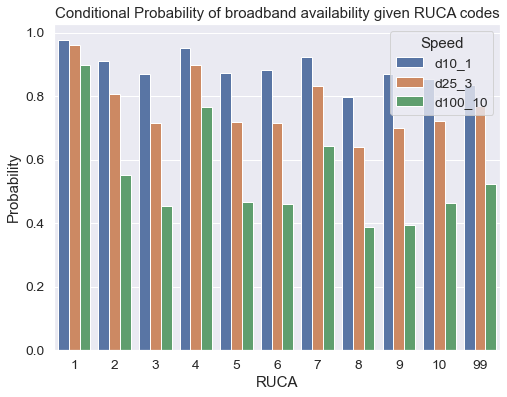

In [21]:
sns.set(style='darkgrid', font_scale=1.25)
sns.barplot(x='ruca', y='Pr', hue='Speed', 
            data=broadband_ruca_df.reset_index().melt(
                id_vars=['ruca'],value_vars=['d10_1','d25_3','d100_10'], 
                value_name='Pr', var_name='Speed'))
plt.title('Conditional Probability of broadband availability given RUCA codes')
plt.xlabel('RUCA')
plt.ylabel('Probability');


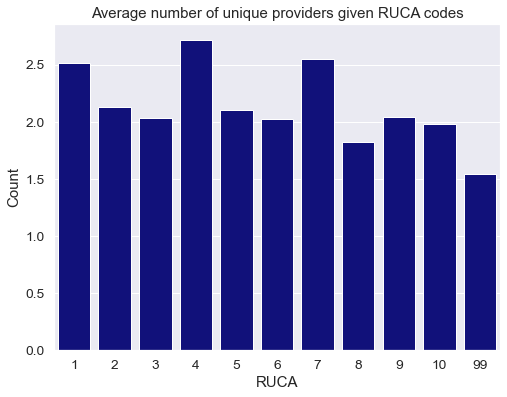

In [72]:
# Assume zero for blocks with no record
subset = combined_df.loc[-combined_df['ruca'].isna(),['ProviderCount','ruca']].fillna(0).astype(int)

broadband_ruca_df = subset.dropna(subset=['ruca']).groupby('ruca').agg(
    ProviderCount = pd.NamedAgg(column='ProviderCount', aggfunc=np.mean) )
broadband_ruca_df.round(3)

sns.set(style='darkgrid', font_scale=1.25)
sns.barplot(x='ruca', y='Pr', color="darkblue",
            data=broadband_ruca_df.reset_index().melt(
                id_vars=['ruca'],value_vars=['ProviderCount'], 
                value_name='Pr', var_name='Speed'))
plt.title('Average number of unique providers given RUCA codes')
plt.xlabel('RUCA')
plt.ylabel('Count');

According to the RUCA code documentation [here](https://www.ers.usda.gov/data-products/rural-urban-commuting-area-codes/documentation/), each census tract is evaluated using measures of **population density, urbanization, and daily commuting flows**. 

- Under this categorization, RUCA codes 1, 4 and 7 can be viewed as the ***core*** of a larger surrounding community, regardless of its size ('metropolitan', 'micropolitan' and 'small town'). For the three codes, the conditional probabilities of broadband availability are higher than other non-core areas.
- Codes (2,3 - metropolitan area), (5,6 - micropolitan area), and (8,9 - small town) can be viewed as the ***peripheries***  around the cores. It is evident that the closer the area is to the core, the higher the probability of broadband availability.
- Code 10 (rural area) is unique in its own way as it's a small self-sufficient community that is neither metropolitan nor micropolitan.
- Blocks with code 99 (no assignment due to lack of population) still show meaningful probabilities of broadband availability. This figure might seem counterintuitive. I see possible the following explanations.
    - RUCA was calculated based on the data from the 2010 Decennial Census, while we’re using the latest information from Form 477. This is about a decade long gap. New inhabitants might have settled in the area since 2010 and service providers expanded. We can check this by comparing RUCA code 99 to 2019 block-level population estimates by FCC staff.
    - Broadband requires fixed infrastructure linking physical locations. If a provider is investing in the infrastructure linking two distant areas, the infrastructure will be installed in the shortest distance possible rather than going around the uninhabited areas on purpose.  

In [78]:
# Create dummies
subset = combined_df.loc[-combined_df['ruca'].isna(),['D10_1','D25_3','D100_10','ProviderCount','ruca','pop2019','AREALAND']]

subset['core'] = 0
subset.loc[subset['ruca'].isin([1,4,7]),'core'] = 1

subset['suburb'] = 0
subset.loc[subset['ruca'].isin([2,5,8]),'suburb'] = 1

subset['exurb'] = 0
subset.loc[subset['ruca'].isin([3,6,9]),'exurb'] = 1

subset['rural'] = 0
subset.loc[subset['ruca'] == 10,'rural'] = 1

subset['remote'] = 0
subset.loc[subset['ruca'] == 99,'remote'] = 1

# Fix data type
subset[['D10_1','D25_3','D100_10']] = subset[['D10_1','D25_3','D100_10']].astype(int)

# Density
subset['density'] = subset['pop2019']/(subset['AREALAND']*0.38610)

In [87]:
import statsmodels.api as sm
from statsmodels.formula.api import logit

formula = 'D25_3 ~ core + suburb + exurb + rural + density'

d25_3_mod = logit(formula, data = subset).fit()
print(d25_3_mod.summary())

/Users/kenny/opt/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:1810: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/kenny/opt/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:1863: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.
         Current function value: inf
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                  D25_3   No. Observations:              9019015
Model:                          Logit   Df Residuals:                  9019009
Method:                           MLE   Df Model:                            5
Date:                Fri, 14 May 2021   Pseudo R-squ.:                    -inf
Time:                        09:08:24   Log-Likelihood:                   -inf
converged:                       True   LL-Null:                   -3.6692e+06
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.6745      0.079     21.066      0.000       1.519       1.830
core           0.5095      0.080 

In [93]:
const = 1.6745 
beta_i = 0.5095 
control = np.exp(const) / (1 + np.exp(const))
marginal_effect = np.exp(beta_i) / (1 - control + (control * np.exp(beta_i)))
print("Core blocks are {}% more likely to get broadband availability, all else equal".format(round((marginal_effect-1)*100)))

beta_i = -0.6128
control = np.exp(const) / (1 + np.exp(const))
marginal_effect = np.exp(beta_i) / (1 - control + (control * np.exp(beta_i)))
print("Suburb blocks are {}% more likely to get broadband availability, all else equal".format(round((marginal_effect-1)*100)))

beta_i = -0.8579
control = np.exp(const) / (1 + np.exp(const))
marginal_effect = np.exp(beta_i) / (1 - control + (control * np.exp(beta_i)))
print("Exburb blocks are {}% more likely to get broadband availability, all else equal".format(round((marginal_effect-1)*100)))

beta_i = -0.7838
control = np.exp(const) / (1 + np.exp(const))
marginal_effect = np.exp(beta_i) / (1 - control + (control * np.exp(beta_i)))
print("Rural blocks are {}% more likely to get broadband availability, all else equal".format(round((marginal_effect-1)*100)))

Core blocks are 7% more likely to get broadband availability, all else equal
Suburb blocks are -12% more likely to get broadband availability, all else equal
Exburb blocks are -18% more likely to get broadband availability, all else equal
Rural blocks are -16% more likely to get broadband availability, all else equal


In [90]:
# Create dummies
subset = combined_df.loc[-combined_df['ruca'].isna(),['D10_1','D25_3','D100_10','ProviderCount','ruca','pop2019','AREALAND']]

subset['metro'] = 0
subset.loc[subset['ruca'].isin([1,2,3]),'metro'] = 1

subset['micro'] = 0
subset.loc[subset['ruca'].isin([4,5,6]),'micro'] = 1

subset['town'] = 0
subset.loc[subset['ruca'].isin([7,8,9]),'town'] = 1

subset['rural'] = 0
subset.loc[subset['ruca'] == 10,'rural'] = 1

subset['remote'] = 0
subset.loc[subset['ruca'] == 99,'remote'] = 1

# Fix data type
subset[['D10_1','D25_3','D100_10']] = subset[['D10_1','D25_3','D100_10']].astype(int)

# Density
subset['density'] = subset['pop2019']/(subset['AREALAND']*0.38610)

In [91]:
formula = 'D25_3 ~ metro + micro + town + rural + density'

d25_3_mod = logit(formula, data = subset).fit()
print(d25_3_mod.summary())

/Users/kenny/opt/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:1810: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/kenny/opt/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:1863: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.
         Current function value: inf
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                  D25_3   No. Observations:              9019015
Model:                          Logit   Df Residuals:                  9019009
Method:                           MLE   Df Model:                            5
Date:                Fri, 14 May 2021   Pseudo R-squ.:                    -inf
Time:                        09:11:05   Log-Likelihood:                   -inf
converged:                       True   LL-Null:                   -3.6692e+06
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.6508      0.080     20.741      0.000       1.495       1.807
metro          0.1578      0.080 

In [92]:
const = 1.6508 
beta_i = 0.1578 
control = np.exp(const) / (1 + np.exp(const))
marginal_effect = np.exp(beta_i) / (1 - control + (control * np.exp(beta_i)))
print("Metro blocks are {}% more likely to get broadband availability, all else equal".format(round((marginal_effect-1)*100)))

beta_i = -0.4452 
control = np.exp(const) / (1 + np.exp(const))
marginal_effect = np.exp(beta_i) / (1 - control + (control * np.exp(beta_i)))
print("Micro blocks are {}% more likely to get broadband availability, all else equal".format(round((marginal_effect-1)*100)))

beta_i = -0.6882
control = np.exp(const) / (1 + np.exp(const))
marginal_effect = np.exp(beta_i) / (1 - control + (control * np.exp(beta_i)))
print("Small town blocks are {}% more likely to get broadband availability, all else equal".format(round((marginal_effect-1)*100)))

beta_i = -0.7795 
control = np.exp(const) / (1 + np.exp(const))
marginal_effect = np.exp(beta_i) / (1 - control + (control * np.exp(beta_i)))
print("Rural blocks are {}% more likely to get broadband availability, all else equal".format(round((marginal_effect-1)*100)))

Metro blocks are 2% more likely to get broadband availability, all else equal
Micro blocks are -8% more likely to get broadband availability, all else equal
Small town blocks are -14% more likely to get broadband availability, all else equal
Rural blocks are -16% more likely to get broadband availability, all else equal


In [22]:
print("Number of blocks with RUCA code 99: ",len(combined_df.loc[combined_df['ruca'] == 99,'pop2019']))
count, division = np.histogram(combined_df.loc[combined_df['ruca'] == 99,'pop2019'], bins = 10)
pd.DataFrame(data = {'bins' : division[:-1], 'freq' : count})

Number of blocks with RUCA code 99:  2109


bins  freq
0    0.0  2061
1   20.8    39
2   41.6     2
3   62.4     3
4   83.2     2
5  104.0     1
6  124.8     0
7  145.6     0
8  166.4     0
9  187.2     1

In [24]:
print('Block-level population distribution by RUCA code')
population_ruca_df = combined_df.groupby('ruca').agg(avg_pop2019 = pd.NamedAgg(column='pop2019', aggfunc=np.mean),
                          p30_pop2019 = pd.NamedAgg(column='pop2019', aggfunc=lambda x: np.percentile(x, q=25)),
                          p50_pop2019 = pd.NamedAgg(column='pop2019', aggfunc=lambda x: np.percentile(x, q=50)),
                          p70_pop2019 = pd.NamedAgg(column='pop2019', aggfunc=lambda x: np.percentile(x, q=70)),
                          p90_pop2019 = pd.NamedAgg(column='pop2019', aggfunc=lambda x: np.percentile(x, q=90)),
                          p95_pop2019 = pd.NamedAgg(column='pop2019', aggfunc=lambda x: np.percentile(x, q=95)),
                          p99_pop2019 = pd.NamedAgg(column='pop2019', aggfunc=lambda x: np.percentile(x, q=99)))
population_ruca_df


Block-level population distribution by RUCA code


avg_pop2019  p30_pop2019  p50_pop2019  p70_pop2019  p90_pop2019  \
ruca                                                                    
1.0     60.373141            4           29           58          137   
2.0     22.710690            0            6           18           58   
3.0     16.040634            0            4           13           43   
4.0     24.240524            0            9           24           60   
5.0     12.490636            0            2            9           34   
6.0     13.571059            0            4           12           37   
7.0     15.369676            0            5           15           39   
8.0      9.281783            0            2            7           25   
9.0     11.537953            0            3           10           32   
10.0     7.298574            0            1            5           19   
99.0     2.675202            0            0            1            8   

      p95_pop2019  p99_pop2019  
ruca                            
1.0           221          552  
2.0            96          234  
3.0            68          156  
4.0            93          220  
5.0            56          133  
6.0            57          120  
7.0            60          138  
8.0            43          101  
9.0            50          105  
10.0           33           82  
99.0           13           30

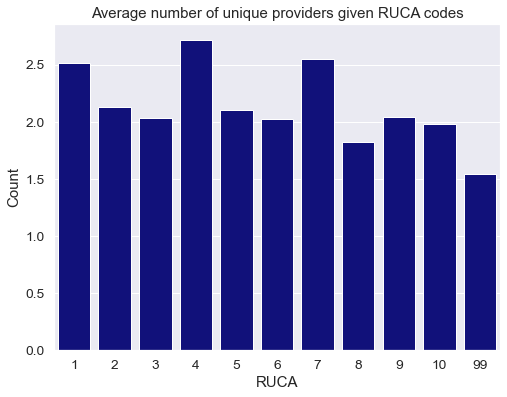

## 2. What are the geographical characteristics of the blocks for which there is no record in Form 477 (i.e., no provider)?

Most blocks without any providers are very sparsely populated. Many of them are completely uninhabited.

In [71]:
no_form477 = combined_df.loc[combined_df['D10_1'].isna(),:]
no_form477['density'] = no_form477['pop2019']/(no_form477['AREALAND']*0.38610)

print('There are {} census blocks with no records of Form 477 data at all.'.format(no_form477.shape[0]))
print('These blocks account for {}% of all blocks in our sample.'.format(round(no_form477.shape[0]/combined_df.shape[0]*100),1))
print('Among the blocks with no providers, {}% of them have zero population.'.format(round(no_form477.loc[no_form477['pop2019']==0,:].shape[0]/no_form477.shape[0]*100),1))
print('Average land area of the blocks with no providers is {} sq. miles.'.format(round(no_form477['AREALAND'].mean()*0.38610*100)/100))
print('Average population density of the blocks with no providers is {} people per sq. mile.'.format(round(no_form477['density'].mean()*10000)/10000))


There are 1715202 census blocks with no records of Form 477 data at all.
These blocks account for 16% of all blocks in our sample.
Among the blocks with no providers, 72% of them have zero population.
Average land area of the blocks with no providers is 414449.7 sq. miles.
Average population density of the blocks with no providers is 0.0012 people per sq. mile.


In [25]:
# Bring in ACS 5-year estimates (2019 vintage)
address2019 = pd.read_csv('../census_address_count/census_block_addresses_2020.csv')
address2019.head()

STATE  COUNTY  TRACT BLOCK      BLOCK_GEOID  TOTAL RESIDENTIAL  \
0      1       1  201.0  1000  010010201001000                 32   
1      1       1  201.0  1001  010010201001001                  0   
2      1       1  201.0  1002  010010201001002                  1   
3      1       1  201.0  1003  010010201001003                 38   
4      1       1  201.0  1004  010010201001004                  0   

   TOTAL GROUP QUARTERS  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0

There are "sub"-blocks in this data. For example, in Alabama county 001, tract 205, there are two block 2003--2003A and 2003B. Merge those to be consistent with the 2010 Decennial Census geocodes. 

In [28]:
address2019['GEOID'] = address2019.loc[:,"BLOCK_GEOID"].str[:15]

address2019 = address2019.groupby('GEOID').agg(res_adrs = pd.NamedAgg('TOTAL RESIDENTIAL','sum'),
                                  gq_adrs = pd.NamedAgg('TOTAL GROUP QUARTERS','sum'))

address2019 = address2019.reset_index()

In [29]:
combined_df = pd.merge(left=combined_df, right=address2019, left_on='BlockCodeStr', right_on='GEOID', how='left')
combined_df.drop(['GEOID'], axis=1, inplace=True)

BlockCodeStr    TractCode BlockGroupCode D10_1 D25_3 D100_10  \
0         010010201001000  01001020100   010010201001  True  True    True   
1         010010201001001  01001020100   010010201001  True  True    True   
2         010010201001002  01001020100   010010201001  True  True    True   
3         010010201001003  01001020100   010010201001  True  True    True   
4         010010201001004  01001020100   010010201001  True  True    True   
...                   ...          ...            ...   ...   ...     ...   
11007984  560459513003125  56045951300   560459513003   NaN   NaN     NaN   
11007985  560459513003126  56045951300   560459513003   NaN   NaN     NaN   
11007986  560459513003127  56045951300   560459513003  True  True    True   
11007987  560459513003128  56045951300   560459513003   NaN   NaN     NaN   
11007988  560459513003129  56045951300   560459513003   NaN   NaN     NaN   

          ProviderCount state          county  ruca  pop2019     pop  cnipop  \
0                   3.0    AL  Autauga County   1.0       64   730.0   730.0   
1                   1.0    AL  Autauga County   1.0        0   730.0   730.0   
2                   2.0    AL  Autauga County   1.0        1   730.0   730.0   
3                   2.0    AL  Autauga County   1.0       77   730.0   730.0   
4                   1.0    AL  Autauga County   1.0        0   730.0   730.0   
...                 ...   ...             ...   ...      ...     ...     ...   
11007984            NaN   NaN             NaN   NaN        0  1277.0  1277.0   
11007985            NaN   NaN             NaN   NaN        0  1277.0  1277.0   
11007986            2.0    WY   Weston County   7.0       15  1277.0  1277.0   
11007987            NaN   NaN             NaN   NaN        0  1277.0  1277.0   
11007988            NaN   NaN             NaN   NaN        0  1277.0  1277.0   

          inspopshr  mpop    colpop   AREALAND            GEOID  res_adrs  \
0               0.0   0.0  11.09589   482628.0  010010201001000      32.0   
1               0.0   0.0  11.09589      482.0  010010201001001       0.0   
2               0.0   0.0  11.09589     3495.0  010010201001002       1.0   
3               0.0   0.0  11.09589   560352.0  010010201001003      38.0   
4               0.0   0.0  11.09589      748.0  010010201001004       0.0   
...             ...   ...       ...        ...              ...       ...   
11007984        0.0   0.0   0.00000  1195729.0  560459513003125       0.0   
11007985        0.0   0.0   0.00000    78884.0  560459513003126       1.0   
11007986        0.0   0.0   0.00000     8055.0  560459513003127       6.0   
11007987        0.0   0.0   0.00000    59648.0  560459513003128       0.0   
11007988        0.0   0.0   0.00000    85544.0  560459513003129       0.0   

          gq_adrs  
0             0.0  
1             0.0  
2             0.0  
3             0.0  
4             0.0  
...           ...  
11007984      0.0  
11007985      0.0  
11007986      0.0  
11007987      0.0  
11007988      0.0  

[11007989 rows x 20 columns]

In [ ]:
merged.info()